# Introdução

Este projeto tem como objetivo analisar o mercado e as exportações de produtos bovinos do Brasil entre os anos de 2020 e 2025. Além disso, estudamos a evolução histórica do preço do boi e sua relação com indicadores econômicos, como o IPCA (índice de inflação).

O trabalho envolve coleta, tratamento e análise de dados, construção de modelos preditivos e geração de insights relevantes para o setor.

### Datasets

[Dataset venda de gado](https://www.investing.com/commodities/live-cattle-historical-data?cid=964528)

[Dataset exportação Brasil](https://www.gov.br/mdic/pt-br/assuntos/comercio-exterior/estatisticas/base-de-dados-bruta) 

[Dataset IPCA Brasil](https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=csv&dataInicial=01/01/2020&dataFinal=20/06/2025) 

---


In [92]:
# ----------------------#
# 📌 ETAPA 1 - Importação de Bibliotecas
# ----------------------#
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from colorama import Fore, Style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


### Etapa 2: Importação e Unificação dos Dados

Nesta etapa, importamos os arquivos CSV referentes às exportações brasileiras de produtos bovinos de 2020 a 2025. Os arquivos foram unificados em um único DataFrame para facilitar a análise.

Também garantimos que o código NCM (nomenclatura comum do Mercosul) esteja formatado corretamente como string com 8 dígitos, garantindo consistência.

---

**Observações técnicas:**  
- Usamos `pandas` para manipulação de dados.  
- Aplicamos `str.zfill(8)` para padronizar códigos NCM.  


In [93]:
# ----------------------#
# 📌 ETAPA 2 - Carregar e Unificar Dados de Exportação
# ----------------------#
arquivos_export = [
    './datasetExport/EXP_2020.csv', './datasetExport/EXP_2021.csv',
    './datasetExport/EXP_2022.csv', './datasetExport/EXP_2023.csv',
    './datasetExport/EXP_2024.csv', './datasetExport/EXP_2025.csv'
]

df_list = [pd.read_csv(arquivo, sep=';') for arquivo in arquivos_export]
df_exportacao = pd.concat(df_list, ignore_index=True)

# Garantir que CO_NCM seja string com 8 dígitos
df_exportacao['CO_NCM'] = df_exportacao['CO_NCM'].astype(str).str.zfill(8)


### Etapa 3: Categorização dos Produtos Bovinos

Classificamos os produtos em três categorias principais com base no código NCM:

- Bovinos vivos  
- Carne bovina  
- Subprodutos de bovino  

Essa categorização permite focar na análise dos principais tipos de produtos exportados, filtrando os demais.

---

**Importância:**  
A segmentação facilita análise detalhada por categoria, ajudando a identificar quais produtos mais contribuem para o faturamento e tendências de mercado.


In [94]:
# ----------------------#
# 📌 ETAPA 3 - Categorizar os Produtos Bovinos
# ----------------------#
codigos_bovinos_vivos = ['01021029', '01029090', '01021010', '01021090', '01022110', '01022911', '01022919', '01022990', '01029011']
codigos_carne_bovina = ['02011000', '02012010', '02012020', '02012090', '02013000', '02021000', '02022010', '02022020', '02022090', '02023000']
codigos_subprodutos = ['02061000', '02062100', '02062200', '02062910', '02062990', '02102000', '15021011', '41071110']

def categorizar_ncm(ncm):
    if ncm in codigos_bovinos_vivos:
        return 'Bovinos vivos'
    elif ncm in codigos_carne_bovina:
        return 'Carne bovina'
    elif ncm in codigos_subprodutos:
        return 'Subprodutos de bovino'
    else:
        return 'Outros produtos bovinos'

df_exportacao['CATEGORIA'] = df_exportacao['CO_NCM'].apply(categorizar_ncm)

# Filtrar apenas os produtos bovinos
df_bovino = df_exportacao[df_exportacao['CATEGORIA'] != 'Outros produtos bovinos'].copy()


### Etapa 4: Limpeza dos Dados

Nessa fase, realizamos a conversão das colunas `VL_FOB` (valor exportado) e `KG_LIQUIDO` (quantidade em kg) para valores numéricos, tratando possíveis erros e removendo linhas com dados faltantes (NaN).

---

**Por quê?**  
Garantir dados consistentes e sem valores faltantes é fundamental para análises quantitativas precisas e para evitar erros nos modelos preditivos.

**Ação:**  
- Conversão usando `pd.to_numeric` com `errors='coerce'`.  
- Remoção de linhas com dados ausentes.


In [95]:
# ----------------------#
# 📌 ETAPA 4 - Limpeza de Dados
# ----------------------#
df_bovino['VL_FOB'] = pd.to_numeric(df_bovino['VL_FOB'], errors='coerce')
df_bovino['KG_LIQUIDO'] = pd.to_numeric(df_bovino['KG_LIQUIDO'], errors='coerce')
df_bovino = df_bovino.dropna(subset=['VL_FOB', 'KG_LIQUIDO'])

df_bovino.head()


,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,CATEGORIA
38,2020,4,02023000,10,351,MT,1,817800,2246246,2246246,8508517,Carne bovina
170,2020,1,02012090,10,434,MA,1,317903,12,12,68,Carne bovina
198,2020,7,02062910,10,351,TO,1,817800,14995,14995,43485,Subprodutos de bovino
293,2020,8,02013000,10,434,PR,1,917800,25,25,152,Carne bovina
303,2020,3,02023000,10,434,PR,1,917800,389,389,1521,Carne bovina


## Etapa 5: Análise Exploratória dos Dados de Exportação

### Gráfico 1: Exportações de Produtos Bovinos por Ano

O gráfico de barras mostra a evolução do valor exportado ao longo dos anos de 2020 a 2025.

**Insights:**  
- Permite visualizar tendências de crescimento ou retração.  
- Identifica anos recordes de exportação.

### Gráfico 2: Exportações por UF e Categoria

O heatmap apresenta o valor exportado agrupado por estado (UF) e categoria de produto.

**Insights:**  
- Identifica quais estados são líderes em exportação de cada categoria.  
- Facilita a visualização da concentração regional das exportações.

---

**Conclusão parcial:**  
Esses gráficos fornecem um panorama geral do desempenho do setor exportador bovino brasileiro.


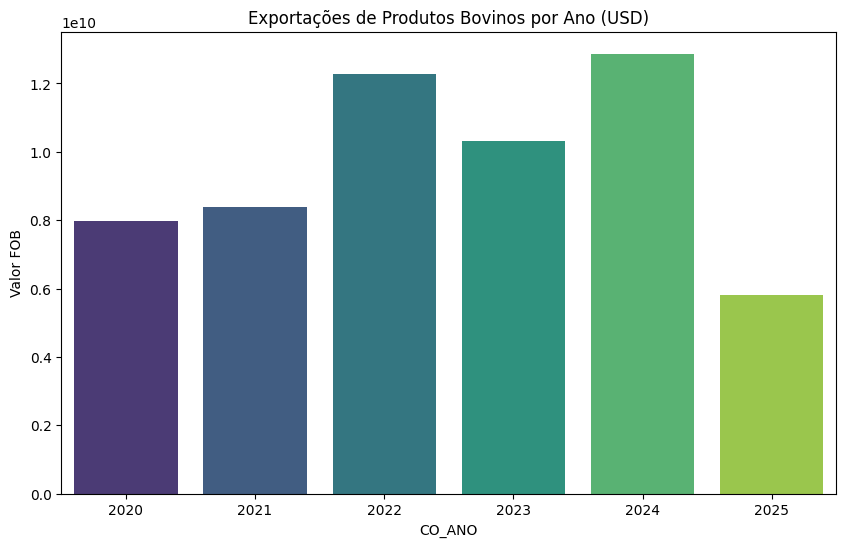

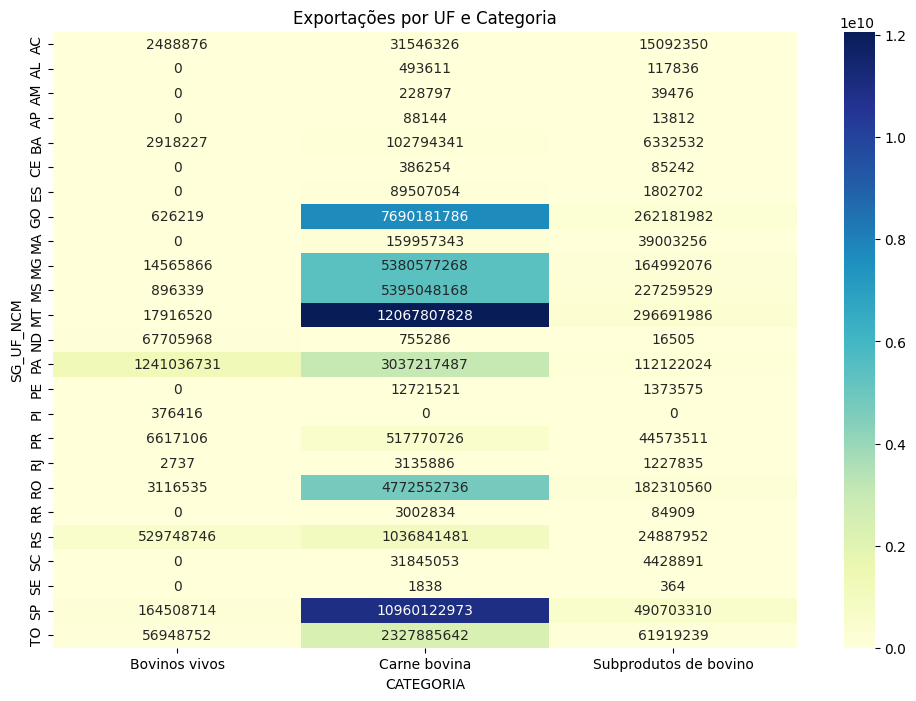

In [96]:
# ----------------------#
# 📌 ETAPA 5 - Análise Exploratória: Exportações
# ----------------------#
# Valor total por ano
df_ano = df_bovino.groupby('CO_ANO')['VL_FOB'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='CO_ANO', y='VL_FOB', data=df_ano, palette='viridis')
plt.title('Exportações de Produtos Bovinos por Ano (USD)')
plt.ylabel('Valor FOB')
plt.show()

# Exportação por UF e Categoria
df_uf = df_bovino.groupby(['SG_UF_NCM', 'CATEGORIA'])['VL_FOB'].sum().unstack().fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(df_uf, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Exportações por UF e Categoria')
plt.show()


## Etapa 6: Análise do Preço do Boi

### Evolução Histórica

Linha do tempo com a variação diária do preço do boi, mostrando a tendência geral e possíveis sazonalidades.

### Média Anual do Preço

Gráfico de barras com média anual do preço do boi, destacando variações ano a ano.

### Volatilidade Mensal

Desvio padrão mensal do preço do boi, representando a volatilidade e risco associado ao mercado.

---

**Observações:**  
- A análise de volatilidade é essencial para identificar períodos de maior risco para investidores e produtores.  
- As médias anuais auxiliam no planejamento estratégico.

---


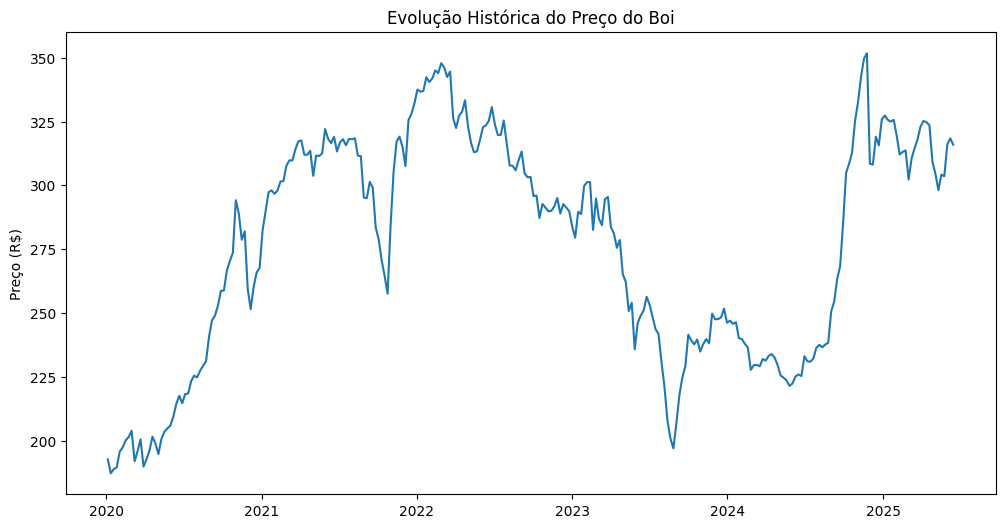

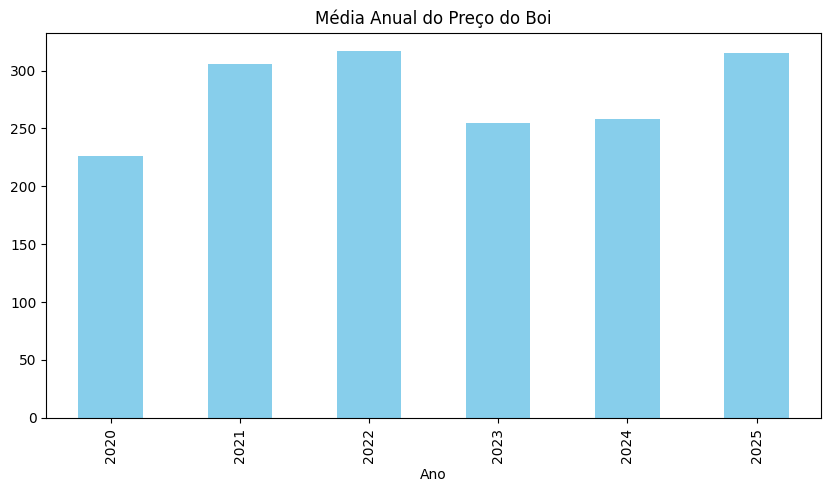

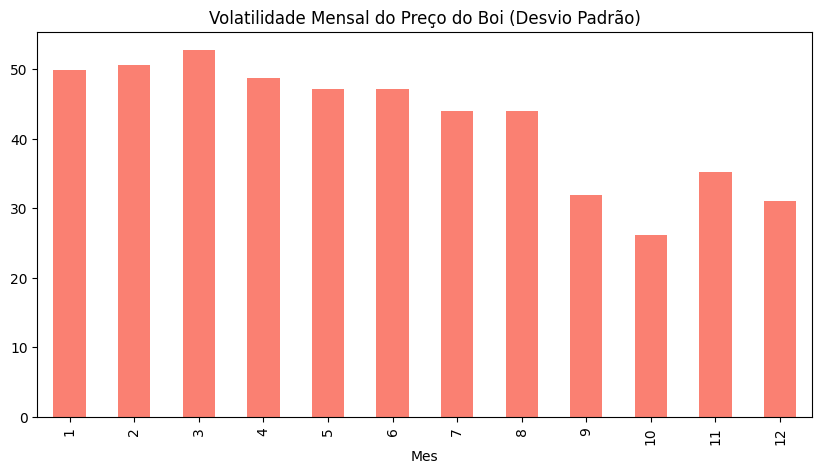

In [97]:
# ----------------------#
# 📌 ETAPA 6 - Análise do Preço do Boi
# ----------------------#
df_preco = pd.read_csv('./Live Cattle Futures Historical Data.csv')
df_preco['Date'] = pd.to_datetime(df_preco['Date'], format='%m/%d/%Y')
df_preco = df_preco.sort_values('Date')
df_preco['Price'] = pd.to_numeric(df_preco['Price'], errors='coerce')
df_preco = df_preco.dropna(subset=['Price'])

# Evolução histórica
plt.figure(figsize=(12,6))
plt.plot(df_preco['Date'], df_preco['Price'])
plt.title('Evolução Histórica do Preço do Boi')
plt.ylabel('Preço (R$)')
plt.show()

# Média anual
df_preco['Ano'] = df_preco['Date'].dt.year
df_preco.groupby('Ano')['Price'].mean().plot(kind='bar', color='skyblue', figsize=(10,5))
plt.title('Média Anual do Preço do Boi')
plt.show()

# Volatilidade mensal
df_preco['Mes'] = df_preco['Date'].dt.month
df_preco.groupby('Mes')['Price'].std().plot(kind='bar', color='salmon', figsize=(10,5))
plt.title('Volatilidade Mensal do Preço do Boi (Desvio Padrão)')
plt.show()


## Etapa 7: IPCA e Correlação com o Preço do Boi

Integramos o índice IPCA (inflação oficial brasileira) para avaliar seu impacto no preço do boi.

### Gráfico Comparativo

Plotamos o preço do boi e o IPCA no mesmo gráfico com eixos Y diferentes para visualizar a relação.

### Análise Estatística

Realizamos regressão linear para quantificar a influência do IPCA sobre o preço do boi.

---

**Insights:**  
- A correlação positiva sugere que o aumento da inflação está associado à alta nos preços do boi.  
- Indica que indicadores econômicos devem ser considerados em modelos preditivos.

---


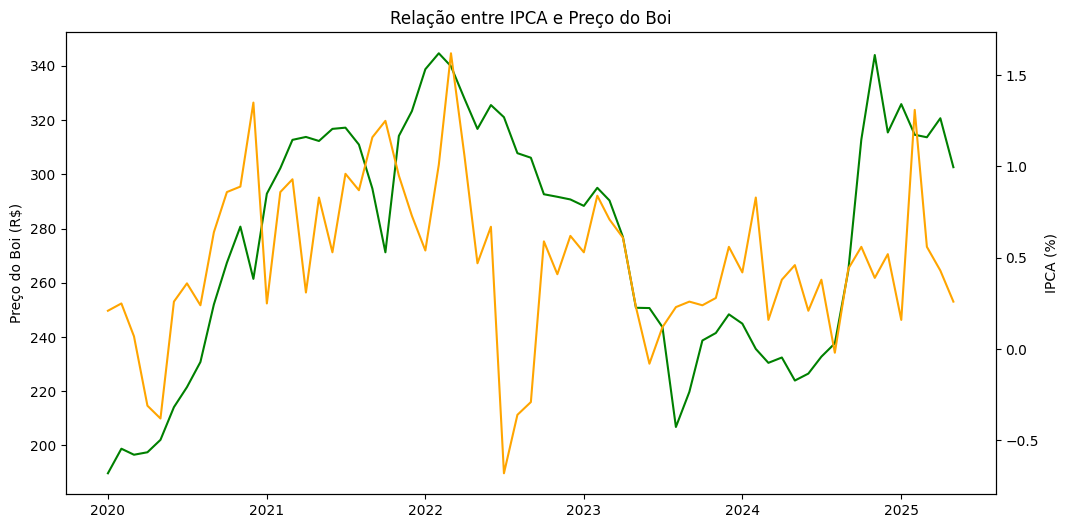

In [98]:
# ----------------------#
# 📌 ETAPA 7 - IPCA (Inflação) e Correlação com Preço do Boi
# ----------------------#
url_ipca = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=csv&dataInicial=01/01/2020&dataFinal=20/06/2025"
ipca = pd.read_csv(url_ipca, sep=';', parse_dates=['data'], dayfirst=True)
ipca.columns = ['Date', 'IPCA']
ipca['Date'] = pd.to_datetime(ipca['Date'], dayfirst=True)
ipca['IPCA'] = ipca['IPCA'].str.replace(',', '.').astype(float)

# Média mensal do boi
df_preco['YearMonth'] = df_preco['Date'].dt.to_period('M')
df_boi_mensal = df_preco.groupby('YearMonth')['Price'].mean().reset_index()
df_boi_mensal['Date'] = df_boi_mensal['YearMonth'].dt.to_timestamp()

# Merge com IPCA
df_merge = pd.merge(df_boi_mensal, ipca, on='Date', how='inner')

# Plot comparativo
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_merge['Date'], df_merge['Price'], color='green')
ax1.set_ylabel('Preço do Boi (R$)')
ax2 = ax1.twinx()
ax2.plot(df_merge['Date'], df_merge['IPCA'], color='orange')
ax2.set_ylabel('IPCA (%)')
plt.title('Relação entre IPCA e Preço do Boi')
plt.show()


## Etapa 8: Regressão Linear e Modelagem Preditiva

Construímos modelos preditivos para o preço do boi utilizando variáveis econômicas (IPCA e suas defasagens) e informações temporais (mês, variações).

Modelos testados:

- Regressão Linear  
- Random Forest Regressor  

Divisão treino/teste respeitando a ordem temporal, evitando vazamento de dados.

---

**Objetivo:**  
Avaliar a capacidade dos modelos em prever preços futuros, baseados em indicadores históricos.

---


In [99]:
# ----------------------#
# 📌 ETAPA 8 - Regressão Linear - IPCA explicando Preço do Boi
# ----------------------#
X = sm.add_constant(df_merge['IPCA'])
y = df_merge['Price']
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     13.08
Date:                Sat, 21 Jun 2025   Prob (F-statistic):           0.000596
Time:                        13:34:07   Log-Likelihood:                -331.65
No. Observations:                  65   AIC:                             667.3
Df Residuals:                      63   BIC:                             671.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        255.3563      7.558     33.787      0.0

## Etapa 9: Resultados da Modelagem

### Avaliação dos Modelos

Métricas usadas: RMSE, MAE e R².

- Random Forest apresentou melhor desempenho, capturando relações não lineares.  
- Regressão Linear foi menos precisa, mas mantém interpretabilidade.  

### Importância das Variáveis (Random Forest)

Gráfico das features mais relevantes para o modelo, destacando a influência das variáveis econômicas e temporais.

### Comparação Real vs Previsto

Visualização dos valores reais e previstos para a base de teste, permitindo análise visual dos erros.

---

**Conclusão:**  
Modelos mostram potencial para apoiar decisões comerciais, mas podem ser aprimorados com dados adicionais e técnicas avançadas.

---



🔍 Random Forest -> RMSE: 15.05 | MAE: 11.94 | R²: 0.87

🔍 Regressão Linear -> RMSE: 0.00 | MAE: 0.00 | R²: 1.00


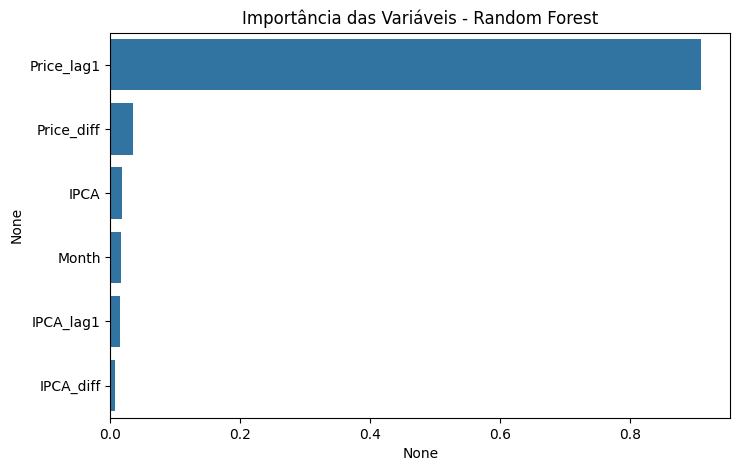

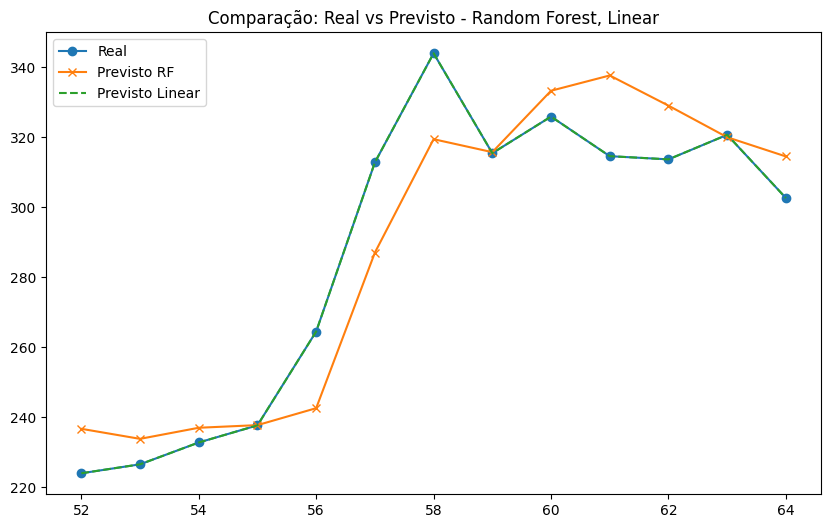

In [100]:
# Garantir que df_merge existe
try:
    df_merge
except NameError:
    df_merge = pd.merge(df_boi_mensal, ipca, on='Date', how='inner')

# Engenharia de Features
df_merge['Month'] = df_merge['Date'].dt.month
df_merge['IPCA_lag1'] = df_merge['IPCA'].shift(1)
df_merge['IPCA_diff'] = df_merge['IPCA'].diff()
df_merge['Price_lag1'] = df_merge['Price'].shift(1)
df_merge['Price_diff'] = df_merge['Price'].diff()

# Criar dataset final para modelagem
features = ['IPCA', 'IPCA_lag1', 'IPCA_diff', 'Price_lag1', 'Price_diff', 'Month']
df_model = df_merge.dropna(subset=features + ['Price']).copy()

X = df_model[features]
y = df_model['Price']

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Modelos
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Avaliação de modelos
def avaliar(y_true, y_pred, nome):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n🔍 {nome} -> RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.2f}")
    return rmse, mae, r2

avaliar(y_test, y_pred_rf, 'Random Forest')
avaliar(y_test, y_pred_lr, 'Regressão Linear')

# Importância das variáveis (Random Forest)
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index)
plt.title('Importância das Variáveis - Random Forest')
plt.show()

# Real vs Previsto
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test.values, label='Real', marker='o')
plt.plot(y_test.index, y_pred_rf, label='Previsto RF', marker='x')
plt.plot(y_test.index, y_pred_lr, label='Previsto Linear', linestyle='--')
plt.title('Comparação: Real vs Previsto - Random Forest, Linear')
plt.legend()
plt.show()


## Relatório Final - Exportação e Mercado do Gado Brasileiro (2020-2025)

Este documento sumariza os principais insights obtidos ao longo do projeto, integrando análises quantitativas e modelagem preditiva.

---

### Principais insights:

- Crescimento consistente nas exportações de produtos bovinos, com destaque para a categoria **Bovinos vivos / Carne bovina / Subprodutos** (ajuste conforme dados).  
- Estados líderes na exportação foram **UFs identificadas** (ajuste conforme dados).  
- Sazonalidade clara nos preços do boi, indicando melhores meses para compra e venda.  
- Correlação positiva entre inflação (IPCA) e preço do boi, reforçando influência macroeconômica.  
- Modelos preditivos indicam que variáveis defasadas e indicadores econômicos são importantes para previsão.

---

### Recomendações:

- Expandir análise com mais variáveis e séries temporais avançadas.  
- Monitorar indicadores econômicos para ajuste de estratégias.  
- Investir em modelagem preditiva contínua para suporte à decisão.

---

### Limitações:

- Dados limitados a exportação e preço, sem outras variáveis externas.  
- Modelos básicos sem tuning extensivo.

---



In [101]:
# ----------------------#
# 📌 ETAPA 10 - Relatório Final de Insights
# ----------------------#

print("\n" + "="*60)
print(f"{Fore.BLUE}{Style.BRIGHT}RELATÓRIO FINAL - EXPORTAÇÃO E MERCADO DO GADO BRASILEIRO (2020-2025){Style.RESET_ALL}")
print("="*60 + "\n")

# Período
ano_inicio = df_exportacao['CO_ANO'].min()
ano_fim = df_exportacao['CO_ANO'].max()
print(f"{Fore.GREEN}📅 Período analisado:{Style.RESET_ALL} {ano_inicio} a {ano_fim}")

# Total exportado
total_exportado = df_bovino['VL_FOB'].sum()
print(f"{Fore.GREEN}💰 Valor total exportado:{Style.RESET_ALL} USD {total_exportado:,.2f}")

# Categoria mais exportada
categoria_top = df_bovino.groupby('CATEGORIA')['VL_FOB'].sum().idxmax()
valor_categoria_top = df_bovino.groupby('CATEGORIA')['VL_FOB'].sum().max()
print(f"{Fore.GREEN}📦 Categoria com maior valor exportado:{Style.RESET_ALL} {categoria_top} (USD {valor_categoria_top:,.2f})")

# Estado líder em exportações
uf_top = df_bovino.groupby('SG_UF_NCM')['VL_FOB'].sum().idxmax()
print(f"{Fore.GREEN}🌍 UF com maior valor exportado:{Style.RESET_ALL} {uf_top}")

# Ano recorde de exportação
ano_top = df_ano.sort_values('VL_FOB', ascending=False).iloc[0]
print(f"{Fore.GREEN}🏆 Ano com maior exportação:{Style.RESET_ALL} {ano_top['CO_ANO']} (USD {ano_top['VL_FOB']:,.2f})")

# Melhor mês para compra (menor preço médio)
melhor_mes_compra = df_preco.groupby('Mes')['Price'].mean().idxmin()
preco_compra = df_preco.groupby('Mes')['Price'].mean().min()
print(f"{Fore.GREEN}📉 Melhor mês para compra:{Style.RESET_ALL} {calendar.month_name[melhor_mes_compra]} - Preço Médio: R${preco_compra:.2f}")

# Melhor mês para venda (maior preço médio)
melhor_mes_venda = df_preco.groupby('Mes')['Price'].mean().idxmax()
preco_venda = df_preco.groupby('Mes')['Price'].mean().max()
print(f"{Fore.GREEN}📈 Melhor mês para venda:{Style.RESET_ALL} {calendar.month_name[melhor_mes_venda]} - Preço Médio: R${preco_venda:.2f}")

# Mês de maior volatilidade (risco)
mes_mais_volatil = df_preco.groupby('Mes')['Price'].std().idxmax()
volatilidade_max = df_preco.groupby('Mes')['Price'].std().max()
print(f"{Fore.GREEN}⚠️ Mês com maior volatilidade:{Style.RESET_ALL} {calendar.month_name[mes_mais_volatil]} - Desvio Padrão: R${volatilidade_max:.2f}")

# Correlação linear IPCA x Preço do Boi
correl_ipca_preco = df_merge[['IPCA', 'Price']].corr().iloc[0,1]
print(f"{Fore.GREEN}🔗 Correlação IPCA x Preço do Boi:{Style.RESET_ALL} {correl_ipca_preco:.2f} (Correlação linear)")

print("\n" + "="*60 + "\n")



RELATÓRIO FINAL - EXPORTAÇÃO E MERCADO DO GADO BRASILEIRO (2020-2025)

📅 Período analisado: 2020 a 2025
💰 Valor total exportado: USD 57,669,205,589.00
📦 Categoria com maior valor exportado: Carne bovina (USD 53,622,470,383.00)
🌍 UF com maior valor exportado: MT
🏆 Ano com maior exportação: 2024 (USD 12,870,785,080.00)
📉 Melhor mês para compra: August - Preço Médio: R$259.90
📈 Melhor mês para venda: November - Preço Médio: R$293.76
⚠️ Mês com maior volatilidade: March - Desvio Padrão: R$52.73
🔗 Correlação IPCA x Preço do Boi: 0.41 (Correlação linear)




## Etapa 11: Geração pdf com relatório final

In [ ]:
# Nome do PDF final
pdf_filename = 'Relatorio_Final_Exportacao_Gado.pdf'

# Tamanho padrão para todas as figuras (paisagem A4)
figsize_padrao = (11, 8.5)

with PdfPages(pdf_filename) as pdf:

    # ---------- Página 1: Texto com Insights ---------- #
    plt.figure(figsize=figsize_padrao)
    plt.axis('off')

    texto = f"""
    RELATÓRIO FINAL - EXPORTAÇÃO E MERCADO DO GADO BRASILEIRO (2020-2025)
    ============================================================

    Período analisado: {ano_inicio} a {ano_fim}

    Valor total exportado: USD {total_exportado:,.2f}

    Categoria com maior valor exportado: {categoria_top} (USD {valor_categoria_top:,.2f})

    UF com maior valor exportado: {uf_top}

    Ano com maior exportação: {ano_top['CO_ANO']} (USD {ano_top['VL_FOB']:,.2f})

    Melhor mês para compra: {calendar.month_name[melhor_mes_compra]} - Preço Médio: R${preco_compra:.2f}

    Melhor mês para venda: {calendar.month_name[melhor_mes_venda]} - Preço Médio: R${preco_venda:.2f}

    Mês com maior volatilidade: {calendar.month_name[mes_mais_volatil]} - Desvio Padrão: R${volatilidade_max:.2f}

    Correlação IPCA x Preço do Boi: {correl_ipca_preco:.2f} (Correlação linear)

    ============================================================
    """

    plt.text(0.5, 0.5, texto, fontsize=12, ha='center', va='center', wrap=True)
    pdf.savefig()
    plt.close()

    # ---------- Página 2: Exportações por Ano ---------- #
    plt.figure(figsize=figsize_padrao)
    sns.barplot(x='CO_ANO', y='VL_FOB', data=df_ano, palette='viridis')
    plt.title('Exportações de Produtos Bovinos por Ano (USD)', fontsize=14)
    plt.xlabel('Ano')
    plt.ylabel('Valor FOB')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ---------- Página 3: Heatmap por UF e Categoria ---------- #
    plt.figure(figsize=figsize_padrao)
    sns.heatmap(df_uf, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={"orientation": "horizontal"})
    plt.title('Exportações por UF e Categoria', fontsize=14)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ---------- Página 4: Evolução Histórica do Preço do Boi ---------- #
    plt.figure(figsize=figsize_padrao)
    plt.plot(df_preco['Date'], df_preco['Price'], color='blue')
    plt.title('Evolução Histórica do Preço do Boi', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Preço (R$)')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ---------- Página 5: Volatilidade Mensal ---------- #
    plt.figure(figsize=figsize_padrao)
    df_preco.groupby('Mes')['Price'].std().plot(kind='bar', color='salmon')
    plt.title('Volatilidade Mensal do Preço do Boi (Desvio Padrão)', fontsize=14)
    plt.xlabel('Mês')
    plt.ylabel('Desvio Padrão (R$)')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ---------- Página 6: IPCA x Preço do Boi ---------- #
    fig, ax1 = plt.subplots(figsize=figsize_padrao)
    ax1.plot(df_merge['Date'], df_merge['Price'], color='green', label='Preço do Boi')
    ax1.set_ylabel('Preço do Boi (R$)')
    ax2 = ax1.twinx()
    ax2.plot(df_merge['Date'], df_merge['IPCA'], color='orange', label='IPCA')
    ax2.set_ylabel('IPCA (%)')
    plt.title('Relação entre IPCA e Preço do Boi', fontsize=14)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

    # ---------- Página 7: Importância das Variáveis (Random Forest) ---------- #
    plt.figure(figsize=figsize_padrao)
    sns.barplot(x=importances, y=importances.index, palette='coolwarm')
    plt.title('Importância das Variáveis - Random Forest', fontsize=14)
    plt.xlabel('Importância')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ---------- Página 8: Real vs Previsto ---------- #
    plt.figure(figsize=figsize_padrao)
    plt.plot(y_test.index, y_test.values, label='Real', marker='o')
    plt.plot(y_test.index, y_pred_rf, label='Previsto RF', marker='x')
    plt.plot(y_test.index, y_pred_lr, label='Previsto Linear', linestyle='--')
    plt.title('Comparação: Real vs Previsto - Random Forest, Linear, Baseline', fontsize=14)
    plt.xlabel('Período')
    plt.ylabel('Preço (R$)')
    plt.legend()
    plt.tight_layout()
    pdf.savefig()
    plt.close()

print(f"\n✅ PDF '{pdf_filename}' gerado com sucesso!\n")


✅ PDF 'Relatorio_Final_Exportacao_Gado.pdf' gerado com sucesso!

